In [8]:
!pip install tensorflow

In [9]:
from __future__ import division
import pandas as pd
import numpy as np
import datetime
import re
import time
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import xgboost as xgb
from math import sqrt
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform, randint
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
#import pydot_ng as pydot
from IPython.display import Image
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Reshape
from keras.layers import Concatenate, Dropout
from keras.layers.embeddings import Embedding
from keras.utils import plot_model
from keras.optimizers import SGD
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn import base

ModuleNotFoundError: No module named 'tensorflow.contrib'

In [ ]:
training_data = pd.read_csv("../data/TrainingSet.csv",index_col=0)
submission_labels = pd.read_csv("../data/SubmissionRows.csv", index_col=0)

In [ ]:
'''
training_data_pivotted = training_data.melt(id_vars=['Series Code', 'Country Name'], var_name='Year', value_name='indicator',ignore_index = False, \
                        value_vars=['1972 [YR1972]','1973 [YR1973]','1974 [YR1974]','1975 [YR1975]',\
                                    '1976 [YR1976]','1977 [YR1977]','1978 [YR1978]','1979 [YR1979]', \
                                    '1980 [YR1980]',  '1981 [YR1981]', '1982 [YR1982]', '1983 [YR1983]', \
                                    '1984 [YR1984]','1985 [YR1985]','1986 [YR1986]','1987 [YR1987]', \
                                    '1988 [YR1988]','1989 [YR1989]','1990 [YR1990]','1991 [YR1991]', \
                                    '1992 [YR1992]','1993 [YR1993]','1994 [YR1994]','1995 [YR1995]', \
                                    '1996 [YR1996]', '1997 [YR1997]','1998 [YR1998]','1999 [YR1999]', \
                                    '2000 [YR2000]','2001 [YR2001]','2002 [YR2002]','2003 [YR2003]' , \
                                    '2004 [YR2004]','2005 [YR2005]','2006 [YR2006]','2007 [YR2007]'])


'''
training_data_pivotted = training_data.melt(id_vars=['Series Code', 'Country Name'], var_name='Year', value_name='indicator',ignore_index = False, value_vars=['2005 [YR2005]','2006 [YR2006]','2007 [YR2007]'])


training_data_pivotted['Year'] = training_data_pivotted['Year'].str.extract('(\d+)', expand=False) #.4stype(i4t),'2005 [YR2005]','2006 [YR2006]'

#df = df.sort_values(['Week', 'Product_Code'])

pd.set_option('display.max_colwidth', -1)

training_data_pivotted['Year'] = pd.to_datetime(training_data_pivotted['Year'], format='%Y')

#Ignore data is null 

#df=df[df.indicator.notnull()]

#df.head()

training_data_pivotted.to_csv("../data/training_data_pivotted.csv")

In [ ]:
#Pre-process the data in bigquery, and impute the value of null 

imputed_results_raw=pd.read_csv("../data/imputed_res.csv",index_col='int64_field_0')

imputed_results=imputed_results_raw.join(submission_labels,how='inner')

imputed_results=imputed_results.rename({'Series_Code':'Series Code','Country_Name': 'Country Name'},axis=1)

imputed_results=imputed_results.drop(['2008 [YR2008]','2012 [YR2012]'], axis=1)

#imputed_results["indicator"].max()

imputed_results.groupby('Year').nunique()

#make sure the index is preserved. May not be required
#imputed_results[imputed_results.index == 559]

In [ ]:
#Ensure null values are imputed 
df=imputed_results[imputed_results.indicator.isnull()]
df.head()
#Select only last 3 years data
imputed_results=imputed_results[pd.to_datetime(imputed_results['Year'], format='%Y-%m-%d') >= '1972-01-01']
#imputed_results=imputed_results[imputed_results['Country Name'] == 'Afghanistan']
imputed_results.head()

In [ ]:
#Apply encoding of categorical values 
# Label Encoding 

encode_columns = ['Country Name','Series Code']
encode_df = imputed_results[encode_columns]
encode_df = encode_df.astype('str')
encode_df = encode_df.apply(LabelEncoder().fit_transform)
score_encode_drop = imputed_results.drop(encode_columns, axis = 1)
#score_encode_drop=df

score_encode = pd.concat([score_encode_drop, encode_df], axis = 1)
score_encode['Year']=pd.to_datetime(imputed_results['Year'], format='%Y-%m-%d').dt.year
score_target=score_encode
#score_target.groupby('Country Name').nunique()
score_target.head()

In [ ]:
#Split Train and Test Data
split_date = 2006
df_train = score_target.loc[score_target['Year'] <= split_date].copy()
df_test = score_target.loc[score_target['Year'] > split_date].copy()

def create_features(df, label=None):
    #df['Year'] =  pd.to_datetime(df['Year'], format='%Y').dt.year
    X = df[['Country Name','Series Code','Year']]  
    if label:
        y = df[label]
        return X, y
    return X
X_train, y_train = create_features(df_train, label='indicator')
X_test, y_test = create_features(df_test, label='indicator')

#X_train.count()
X_train.head()
#X_train.groupby('Year').nunique()
#print(create_features(df_train, label='indicator'))

In [ ]:
from skmultilearn.adapt import MLkNN
from scipy.sparse import csr_matrix, lil_matrix
classifier_new = MLkNN(k=10)
# Note that this classifier can throw up errors when handling sparse matrices.
x_train = lil_matrix(x_train).toarray()
y_train = lil_matrix(y_train).toarray()
x_test = lil_matrix(x_test).toarray()
# train
classifier_new.fit(x_train, y_train)
# predict
predictions_new = classifier_new.predict(x_test)
# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions_new))
print("\n")

In [ ]:
'''X = score_target[['Year','Country Name', 'Series Code']]
y = score_target[['indicator']]

def TimeSeriesTrainTestSplit(x, y, test_size):
    
        test_index = int(len(X)*(1-test_size))
    
        X_train = X.iloc[:test_index]
        y_train = y.iloc[:test_index]
        X_test = X.iloc[test_index:]
        y_test = y.iloc[test_index:]
        return X_train, y_train, X_test, y_test
    
X_train, y_train, X_test, y_test = TimeSeriesTrainTestSplit(X,y, 0.2)


# let's try linear Regression model 
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

from sklearn.model_selection import TimeSeriesSplit
ts_cross_val = TimeSeriesSplit(n_splits=5)


from sklearn.model_selection import cross_val_score
cv = cross_val_score(regressor, X_train, y_train, cv = ts_cross_val, scoring= "neg_mean_squared_error")

X_test.head()

y_pred = regressor.predict(X_test)

#rms = sqrt(mean_squared_error(y_test, y_pred), squared=False)
#print ('RMSE:', rms)

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmse_val = rmse(np.array(y_test), np.array(y_pred))
print("rms error is: " + str(rmse_val))


'''

In [ ]:
#Test with simple Regression Model 
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

rms = sqrt(mean_squared_error(y_test, y_pred))
print ('RMSE:', rms)

In [ ]:
# Xboost Model

params = {'colsample_bytree': uniform(0.7, 0.3),
          'gamma': uniform(0, 0.5),
          'learning_rate': uniform(0.003, 0.1), # default 0.1 
          'max_depth': randint(2, 6), # default 3
          'n_estimators': randint(100, 250), # default 100
          'subsample': uniform(0.6, 0.4)}
xgb_model = xgb.XGBRegressor(objective="reg:squarederror",random_state=42)
time_split = TimeSeriesSplit(n_splits = 10)
xgb_search = RandomizedSearchCV(xgb_model,param_distributions=params, random_state=42, n_iter=4, cv=time_split, verbose=1, n_jobs=1, return_train_score=True)
xgb_search.fit(X_train,y_train)

y_pred = xgb_search.predict(X_test)
#y_pred = model.predict(X_test)
rms = sqrt(mean_squared_error(y_test, y_pred))

print ('RMSE:', rms)

In [ ]:
#Random forest Model
model = RandomForestRegressor(n_estimators=200)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rms = sqrt(mean_squared_error(y_test, y_pred))

print ('RMSE:', rms)

In [ ]:
submission_results=submission_labels.join(training_data)

submission_results=submission_results[['Country Name','Series Code']]

submission_results['Year']=2008

submission_results['indicator']=0

#submission_results.head() 

#submission_results.groupby('Year').nunique()


# Label Encoding 


encode_columns = ['Country Name','Series Code']
pred_df = submission_results[encode_columns]
score_predict_drop = submission_results.drop(encode_columns, axis = 1)
pred_df = pred_df.astype('str')
pred_df = pred_df.apply(LabelEncoder().fit_transform)


score_predict_2008 = pd.concat([score_predict_drop, pred_df], axis = 1)

score_predict_2008['Year']=pd.to_datetime(score_predict_2008['Year'],format='%Y').dt.year

res_pred_01 = xgb_search.predict(score_predict_2008[['Country Name','Series Code','Year']])

#res_pred_01 = model.predict(score_predict_2008[['Country Name','Series Code','Year']])


score_predict_2008['predictions'] = res_pred_01

score_predict_2008.head()


In [ ]:
# Importing the matplotlib library
import matplotlib.pyplot as plt
# Declaring the figure or the plot (y, x) or (width, height)
plt.figure(figsize = (12,7))
# Categorical data: Country names
Predictors = ['Year', 'Indicator', 'Country Name', 'Series Code']
# Integer value interms of death counts
Predictions = [0.634903, 0.055296 -0.028926, -0.028926, 0.798667]
# Passing the parameters to the bar function, this is the main function which creates the bar plot
plt.bar(Predictors, Predictions, width= 0.9, align='center',color='cyan', edgecolor = 'red')
# This is the location for the annotated text
i = 1.0
j = 25
# Annotating the bar plot with the values (total death count)
for i in range(len(Predictors)):
    plt.annotate(Predictions[i], (-0.1 + i, Predictions[i] + j))
# Creating the legend of the bars in the plot
plt.legend(labels = ['Predictions'])
# Giving the tilte for the plot
plt.title("Bar plot representing the total deaths by top 6 countries due to coronavirus")
# Namimg the x and y axis
plt.xlabel('Predictors')
plt.ylabel('Predictions')
# Saving the plot as a 'png'
plt.savefig('1BarPlot.png')
# Displaying the bar plot
plt.show()

In [ ]:
submission_results=submission_labels.join(training_data)

submission_results=submission_results[['Country Name','Series Code']]

submission_results['Year']=2012

submission_results['indicator']=0

# Label Encoding 

encode_columns = ['Country Name','Series Code']
pred_df = submission_results[encode_columns]
score_predict_drop = submission_results.drop(encode_columns, axis = 1)
pred_df = pred_df.astype('str')
pred_df = pred_df.apply(LabelEncoder().fit_transform)


score_predict_2012 = pd.concat([score_predict_drop, pred_df], axis = 1)

score_predict_2012['Year']=pd.to_datetime(score_predict_2012['Year'],format='%Y').dt.year

res_pred_01 = xgb_search.predict(score_predict_2012[['Country Name','Series Code','Year']])

#res_pred_01 = model.predict(score_predict_2012[['Country Name','Series Code','Year']])

score_predict_2012['predictions'] = res_pred_01

score_predict_2012.head()

**CYNTHIA ADDED DATA VISUALIZATION**

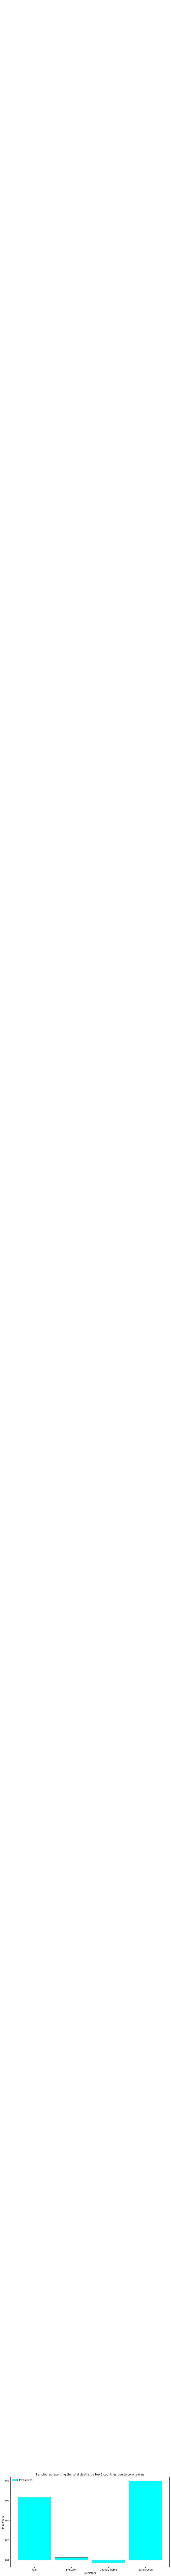

In [10]:
# Importing the matplotlib library
import matplotlib.pyplot as plt
# Declaring the figure or the plot (y, x) or (width, height)
plt.figure(figsize = (12,7))
# Categorical data: Country names
Predictors = ['Year', 'Indicator', 'Country Name', 'Series Code']
# Integer value interms of death counts
Predictions = [0.634903, 0.055296 -0.028926, -0.028926, 0.798667]
# Passing the parameters to the bar function, this is the main function which creates the bar plot
plt.bar(Predictors, Predictions, width= 0.9, align='center',color='cyan', edgecolor = 'red')
# This is the location for the annotated text
i = 1.0
j = 25
# Annotating the bar plot with the values (total death count)
for i in range(len(Predictors)):
    plt.annotate(Predictions[i], (-0.1 + i, Predictions[i] + j))
# Creating the legend of the bars in the plot
plt.legend(labels = ['Predictions'])
# Giving the tilte for the plot
plt.title("Bar plot representing the total deaths by top 6 countries due to coronavirus")
# Namimg the x and y axis
plt.xlabel('Predictors')
plt.ylabel('Predictions')
# Saving the plot as a 'png'
plt.savefig('1BarPlot.png')
# Displaying the bar plot
plt.show()

In [ ]:
predictions_from_model=score_predict_2012.join(score_predict_2008,how='inner',lsuffix=2012, rsuffix=2008)


predictions_from_model=predictions_from_model.drop(columns=['Year2012','indicator2012','Country Name2012','Year2008','indicator2008','Country Name2008','Series Code2012','Series Code2008'])


predictions_from_model=predictions_from_model.rename(columns={"predictions2008": "2008 [YR2008]", "predictions2012": "2012 [YR2012]"})

predictions_from_model=predictions_from_model[['2008 [YR2008]','2012 [YR2012]']]

#predictions_from_model.to_csv("../data/result_xboost_0120_03.csv")


**CYNTHIA CHO TENSORFLOW TEST**

In [ ]:
import pandas
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
# load dataset
dataframe = pandas.read_csv('result_xboost_0120_03.csv', header=None)
#dataframe = predictions_from_model
dataset = dataframe.values
X = dataset[:,0:4].astype(float)
Y = dataset[:,4]
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
 
# define baseline model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(8, input_dim=4, activation='relu'))
	model.add(Dense(3, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
 
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))